In [4]:
%matplotlib inline

In [5]:
import numpy as np
from math import inf
import matplotlib.pyplot as plt
from astrotog import transient_obs_dist as tod
import seaborn
# Import a cosmology, comment out if you want to define your own per the
# astropy cosmology class
from astropy.cosmology import Planck15 as cosmo

In [6]:
import os
import re
import datetime
import csv
import sncosmo
import pandas as pd
from scipy.integrate import simps
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import opsimsummary as oss
import seaborn as sns
# from astrotog import macronovae_wrapper as mw
import macronovae_wrapper as mw
from math import *
from macronova2py import macronova2py as m2p

# font = {'size': 14}
# matplotlib.rc('font', **font)
sns.set_style('whitegrid')  # I personally like this style.
sns.set_context('talk')  # Easy to change context from `talk`, `notebook`, `poster`, `paper`. though further fine tuning is human.

In [7]:
# Imports from package
import os
import re
import numpy as np
import sncosmo
from scipy.integrate import simps
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import opsimsummary as oss
import seaborn as sns
# font = {'size': 14}
# matplotlib.rc('font', **font)
sns.set_style('whitegrid')  # I personally like this style.
sns.set_context('talk')  # Easy to change context from `talk`, `notebook`, `poster`, `paper`. though further fine tuning is human.

In [8]:
# Define directory for locations of SEDS, references, throughputs
paths = {}
paths['seds'] = '/Users/cnsetzer/Documents/LSST/sedb/rosswog/NSNS/winds'
paths['survey'] = '/Users/cnsetzer/Documents/LSST/surveydbs/minion_1016_sqlite.db'
paths['throughputs'] = '/Users/cnsetzer/Documents/LSST/throughputs'
paths['references'] = '/Users/cnsetzer/Documents/LSST/throughputs/references'
# Flag for the survey database retreival to only get a subset of the whole.
db_flag = 'combined'
# Parameter prior for generating the transient KNe distribution
param_priors = {'zmin': 0.0, 'zmax': 0.26, 'z_bin_size': 0.02, 'rate': 1000.0,
                'cosmology': cosmo, 'kappa_min': 1, 'kappa_max': 100,
                'm_ej_min': 0.01, 'm_ej_max': 0.2, 'v_ej_min': 0.01,
                'v_ej_max': 0.5}
instrument_params = {'Instrument': 'lsst', 'FOV_rad': np.deg2rad(1.75),
                     'Mag_Sys': 'ab'}
# Different selections cuts and corresponding limits
Cuts = {'SNR': {'upper': inf, 'lower': 5, 'limit': 0.50}}
# Flag for SED generation to just cycle through SEDs in the database
gen_flag = 'parametric'

In [ ]:
# Initialize the figure number for iterative, functional plotting
fig_num = 1
# Setup the basic running structure
print(' ')
obs_database = tod.Get_ObsStratDB_Summary(paths['survey'], db_flag)
print(' Done reading in observation databse: {}'.format(paths['survey']))

 
 Using OpSimOutput tool to get the database of simulated survey observations.
 reading from database sqlite:////Users/cnsetzer/Documents/LSST/surveydbs/minion_1016_sqlite.db
SELECT * FROM Summary WHERE propID in (56, 54)


In [ ]:
print('\n Getting survey paramters...')
survey_params = tod.Get_Survey_Params(obs_database)
print(' Done retreiving survey paramters.')

In [ ]:
print(' Getting the LSST throughputs and computing the reference fluxes...')
instrument_params = tod.Get_Throughputs(instrument_params, paths)
instrument_params = tod.Get_Reference_Flux(instrument_params, paths)
print(' Done computing instrument parameters.')

### The wrapper function for generating the SEDs

In [ ]:
# Generate the all mock KNe SEDs
# print('\n Generating mock KNe sources...')
# SEDs = tod.Gen_SED_dist(paths['seds'], survey_params, param_priors, gen_flag)
# print(' Done generating mock KNe sources.')

### Investigate the Gen_SED_dist

In [ ]:
SEDdb_path = paths['seds']
# Compile the full parameter space of the generate SEDS
# First compute the z_dist based on the survey parameters as this sets the
# Number of SEDs

In [ ]:
# SEDs = Gen_zDist_SEDs(SEDdb_path, survey_params, param_priors, gen_flag)

### Gen_zDist_SEDs expanded

In [ ]:
Dist_SEDs = {}
# Given survey parameters, a SED rate, and a cosmology draw from a Poisson
# distribution the distribution of the objects vs. redshift.
SED_zlist = list(sncosmo.zdist(zmin=param_priors['zmin'], zmax=param_priors['zmax'],
                               time=survey_params['survey_time'], area=survey_params['survey_area'],
                               ratefunc=tod.SED_Rate(param_priors), cosmo=param_priors['cosmology']))
N_SEDs = len(SED_zlist)
new_keys = list()
print(' The number of mock SEDs being genereated is {}'.format(N_SEDs))
for i in np.arange(N_SEDs):
    new_keys.append('Mock_{}'.format(str(i)))

In [ ]:
# Dist_SEDs = Gen_SED(N_SEDs, new_keys, param_priors, seds_path, gen_flag)
# # Place the SED at the redshift from the redshift distribution calc.

### Expand GEN_SED

In [ ]:
if gen_flag == 'cycle':
    if SEDdb_loc:
        tod.Pick_Rand_dbSED(N_SEDs, new_keys, SEDdb_loc)
elif gen_flag == 'parametric':
    generating_parameters = tod.Draw_KNe_Params(param_priors, new_keys)   

### Explore the parameter space that has been drawn for the generated KNe

In [ ]:
import corner

In [ ]:
p1, p2, p3 = [], [], []
for key in generating_parameters.keys():
    p1.append(generating_parameters[key]['m_ej']) 
    p2.append(generating_parameters[key]['v_ej']) 
    p3.append(generating_parameters[key]['kappa']) 
    
p1 = np.asarray(p1).reshape((len(generating_parameters.keys()),1))
p2 = np.asarray(p2).reshape((len(generating_parameters.keys()),1))
p3 = np.asarray(p3).reshape((len(generating_parameters.keys()),1))

In [ ]:
d_set1 = np.hstack([p1,p2,p3])
print(d_set1)

In [ ]:
value1 = [0.06,0.15,10]

figure = corner.corner(d_set1,labels=[r"$m_{\mathrm{ej}}$", r"$v_{\mathrm{ej}}$", r"$\kappa$"],
                       show_titles=True, title_kwargs={"fontsize": 12})

# Extract the axes
axes = np.array(figure.axes).reshape((3,3))

# Loop over the diagonal
for i in range(3):
    ax = axes[i, i]
    ax.axvline(value1[i], color="r")

# Loop over the histograms
for yi in range(3):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="r")
        ax.axhline(value1[yi], color="r")
        ax.plot(value1[xi], value1[yi], "sr")
        

### Expand Semi_Analytic_KNe

In [ ]:
#Semi_Analytic_KNe(generating_parameters, new_keys)

### Save some of the properties of the SEDs that are generated

In [ ]:
seds_data = {}
seds_props = {}
seds_props['M_u_peak'] = []
seds_props['M_g_peak'] = []
seds_props['M_r_peak'] = []
seds_props['M_i_peak'] = []
seds_props['M_z_peak'] = []
seds_props['M_y_peak'] = []
seds_props['t_peak'] = []
seds_props['L_peak'] = []
seds_props['t_fall'] = []
seds_props['log_lum'] = []
seds_props['delta_L_peak'] = []
seds_props['delta_L_fall'] = []
throughputs = instrument_params['throughputs']
ref_bandflux = deepcopy(instrument_params['Bandflux_References'])

key = new_keys[0]
KNE_parameters = []
KNE_parameters.append(generating_parameters[key]['t_0'])
KNE_parameters.append(generating_parameters[key]['t_f'])
KNE_parameters.append(0.014) # m_ej
KNE_parameters.append(0.125)  # v_ej
KNE_parameters.append(generating_parameters[key]['heatingrate_exp'])
KNE_parameters.append(generating_parameters[key]['thermalization_factor'])
KNE_parameters.append(generating_parameters[key]['DZ_enhancement_factor'])
KNE_parameters.append(1.0) # kappa
KNE_parameters.append(generating_parameters[key]['Initial_Temp'])
KNE_parameters.append(False)
KNE_parameters.append('dummy string')

In [ ]:
Nt = 2000
n = len(KNE_parameters) - 2
MNE_parameters = KNE_parameters[0:n]
read_hrate = KNE_parameters[n]
heating_rates_file = KNE_parameters[n+1]
luminosity = m2p.calculate_luminosity(n, MNE_parameters, read_hrate, heating_rates_file, Nt)
luminosity[:,1] = luminosity[:,1]
phase, wave, flux = mw.SED_timeseries(luminosity, separated=True)
source = sncosmo.TimeSeriesSource(phase, wave, flux)
model = sncosmo.Model(source=source)

In [ ]:
print(luminosity[:,0])

In [ ]:
# Find peak time/index
max_ind = np.argmax(luminosity[:,1])
print(max_ind)
max_lum = np.asscalar(luminosity[max_ind,1])
t_max = np.asscalar(luminosity[max_ind,0])
print(t_max)
t_fall = np.asscalar(luminosity[-1,0] - t_max)
print(t_fall)
delta_l_peak = np.asscalar(luminosity[max_ind,1] - luminosity[0,1])
delta_l_fall = np.asscalar(luminosity[-1,1] - luminosity[max_ind,1])
log_lum = log10(max_lum/pow(10,51))

In [ ]:

mup = model.source_peakmag(band='lsstu',magsys='ab')
mgp = model.source_peakmag(band='lsstg',magsys='ab')
mrp = model.source_peakmag(band='lsstr',magsys='ab')
mip = model.source_peakmag(band='lssti',magsys='ab')
mzp = model.source_peakmag(band='lsstz',magsys='ab')
myp = model.source_peakmag(band='lssty',magsys='ab')

# Save some properties of the models for plotting
seds_props['M_u_peak'].append(mup)
seds_props['M_g_peak'].append(mgp)
seds_props['M_r_peak'].append(mrp)
seds_props['M_i_peak'].append(mip)
seds_props['M_z_peak'].append(mzp)
seds_props['M_y_peak'].append(myp)
seds_props['t_peak'].append(t_max)
seds_props['L_peak'].append(max_lum)
seds_props['t_fall'].append(t_fall)
seds_props['log_lum'].append(log_lum)
seds_props['delta_L_peak'].append(delta_l_peak)
seds_props['delta_L_fall'].append(delta_l_fall)


#     seds_data[key]['model'] = model
#     seds_data[key]['parameters'] = generating_parameters[key]

In [ ]:
import matplotlib.animation as animation

In [ ]:
fig2 = plt.figure()
fig2.tight_layout()
times = np.arange(0,10,0.1)
waves = np.arange(1000,25000,10)
plt.title('SED for Good Fit')
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.ylabel(r'Flux [ergs/s/$cm^2$/$\AA$]')
ims = []

for t in times:
    flux = model.flux(t,waves)
    #ttl = plt.text(0.5, 1.01, 'SED for Good Fit (time = {0}[days])'.format({t}), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    ims.append(plt.plot(waves,flux,color='b',))

im_ani = animation.ArtistAnimation(fig2, ims, interval=250, repeat=False,
                                   blit=True)
# To save this second animation with some metadata, use the following command:
im_ani.save('../../Good_SED.mp4',{'bbox_inches':'tight'})
plt.show()

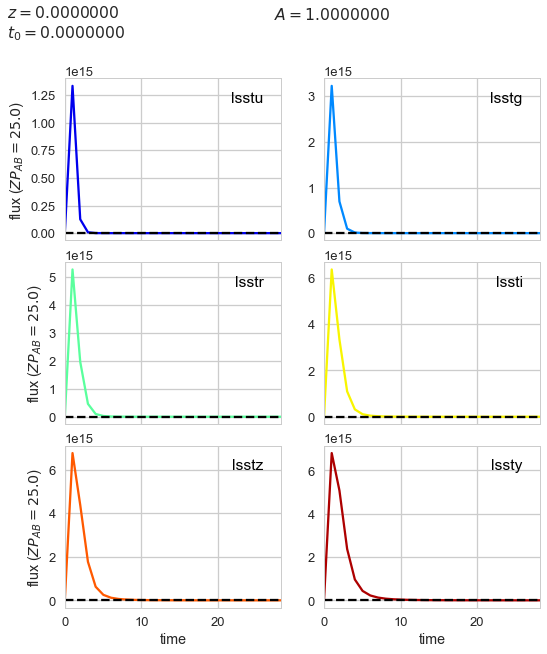

In [27]:
sncosmo.plot_lc(bands=['lsstu','lsstg','lsstr','lssti','lsstz','lssty'],model=model,zpsys='ab')
plt.show()

In [ ]:
Dist_SEDs = Set_SED_Redshift(Dist_SEDs, SED_zlist, param_priors['cosmology'])
SEDs = Dist_SEDs

In [ ]:
key_list = SEDs.keys()
N_SEDs = len(SEDs)
RA_dist, Dec_dist = Ra_Dec_Dist(N_SEDs, survey_params)
t_dist = Time_Dist(N_SEDs, survey_params)
for i, key in enumerate(key_list):
    SEDs[key]['parameters']['z'] = deepcopy(SEDs[key]['model'].get('z'))
    SEDs[key]['parameters']['ra'] = RA_dist[i]
    SEDs[key]['parameters']['dec'] = Dec_dist[i]
    SEDs[key]['parameters']['min_MJD'] = t_dist[i]
    SEDs[key]['parameters']['max_MJD'] = t_dist[i] + SEDs[key]['model'].maxtime()

### Resume normal operation